<a href="https://colab.research.google.com/github/Helyousfi/Brain-Tumor-Classification-Based-google-colab-/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain tumor classification applying transfer learning to the RESNET18 pretrained model
### The RESNET18 architecture :
Link : https://arxiv.org/abs/1512.03385
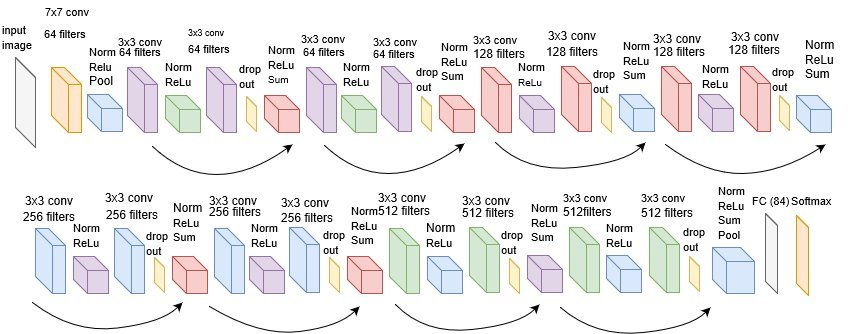

## Some important imports :

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import numpy as np

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [103]:
# Define the mean and standard deviation
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [104]:
data_transforms = {
                      'train' : transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean, std)
                                                    ]),
                      'val' : transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean, std)
                                                ]),
                      'test' : transforms.Compose([
                                                    transforms.Resize(224),
                                                   transforms.ToTensor(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                      ])
} 

In [105]:
data_dir = 'BRAIN_TUMOR/'
sets = ['train', 'val']

In [118]:
!unzip '/content/BRAIN_TUMOR.zip'

In [106]:
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                      for x in sets}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=0)
                      for x in sets}
datasets_sizes = {x : len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes
print(class_names)

['no', 'yes']


### Plot some samples :

label : yes


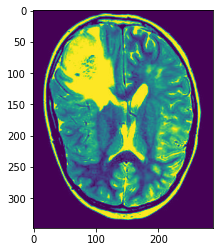

In [107]:
image = cv2.imread(os.path.join(data_dir, 'train/yes/y0.jpg'), cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
print(f"label : {class_names[1]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
0


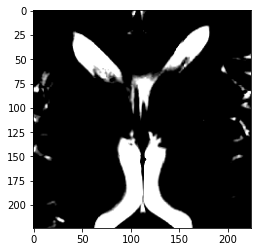

In [108]:
sample = next(iter(image_datasets['train']))
image, label = sample
print(image.shape)
print(label)
plt.imshow(np.transpose(image.numpy(), (1,2,0)))

In [109]:
train_loader = data_loaders['train']
batch = next(iter(train_loader))
images, labels = batch
print(images.shape)

torch.Size([10, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels :  tensor([0])


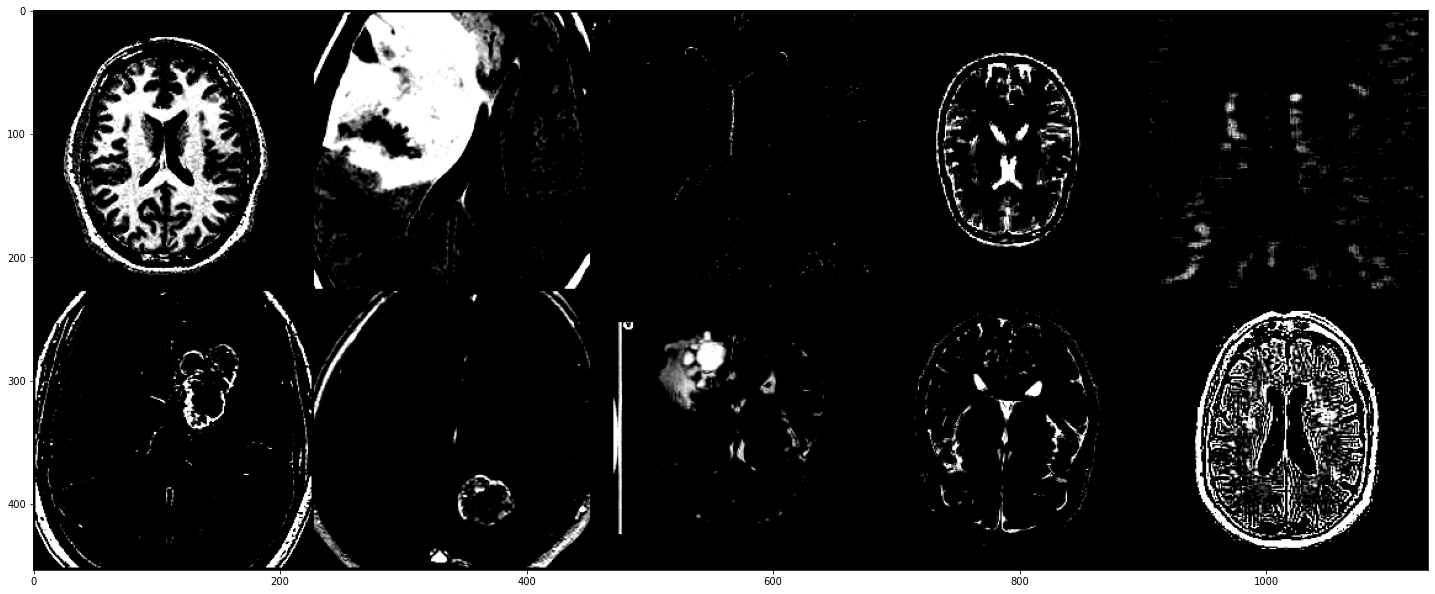

In [118]:
grid = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(25,25))
plt.imshow(np.transpose(grid, (1,2,0)), cmap="jet")
print("Labels : ", labels)

### Function to train the model :

In [111]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 40):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 22)
        # Each epoch has a training and a validation phase 
        for phase in sets:
            if phase == "train":
                model.train() #set the model to training mode
            else:
                model.eval() #set the model to evaluation mode
            running_loss = 0
            running_corrects = 0
            # iterate over data
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #backward
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                if phase == "train":
                    scheduler.step()
                
                epoch_loss = running_loss / datasets_sizes[phase]
                epoch_acc = running_corrects.double() / datasets_sizes[phase]

                if 0:
                  print(f"{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}")

                #deep copy the model
                if phase == "val" and epoch_acc > best_acc :
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
            
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # load model best weights
    model.load_state_dict(best_model_wts)
    return model

### Load the pretrained Model, freeze the parameters and change the fully connected layer :

In [112]:
model = models.resnet18(pretrained=True)
if 0:
  for param in model.parameters():
      param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the Model :

In [116]:
#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if 1:
    model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)
    torch.save(model, 'model.pt')

Epoch 0/1
----------------------
Epoch 1/1
----------------------
Training complete in 0m 46s
Best val Acc: 1.0000


tensor(1)


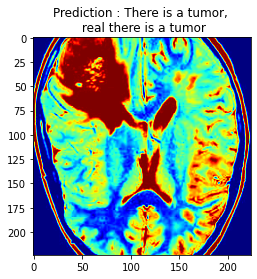

real : tensor([1])
tensor(0)


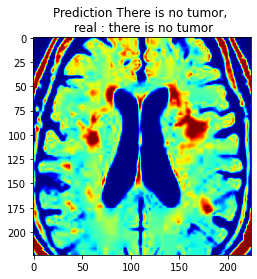

real : tensor([0])
tensor(0)


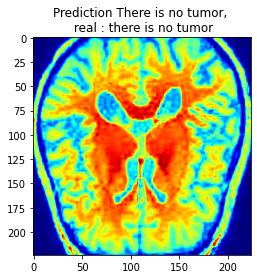

real : tensor([0])
tensor(1)


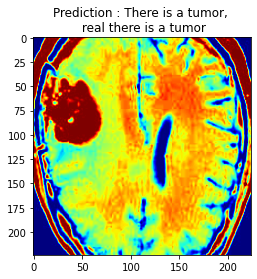

real : tensor([1])
tensor(0)


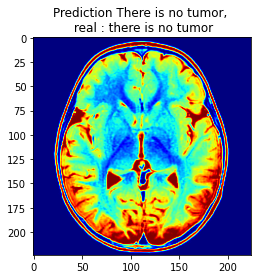

real : tensor([0])
tensor(0)


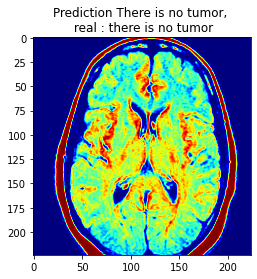

real : tensor([0])
tensor(0)


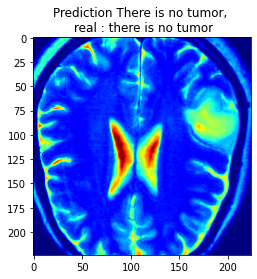

real : tensor([0])
tensor(1)


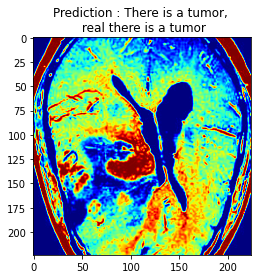

real : tensor([1])
tensor(0)


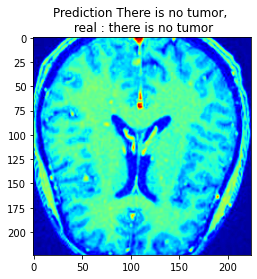

real : tensor([0])
tensor(1)


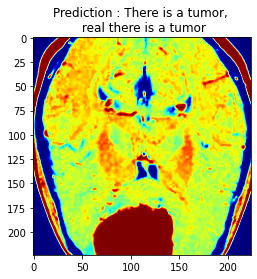

real : tensor([1])
tensor(1)


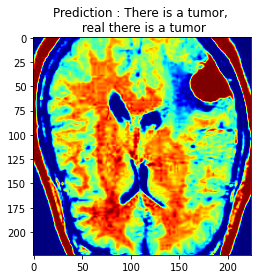

real : tensor([1])
tensor(1)


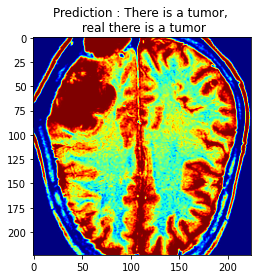

real : tensor([1])
tensor(0)


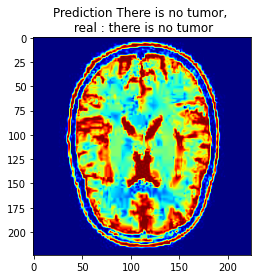

real : tensor([0])
tensor(1)


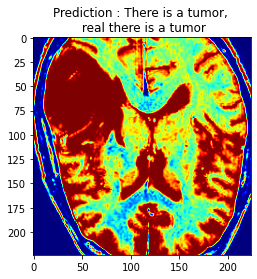

real : tensor([1])
tensor(1)


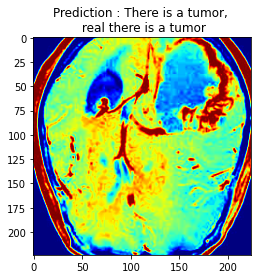

real : tensor([1])
tensor(0)


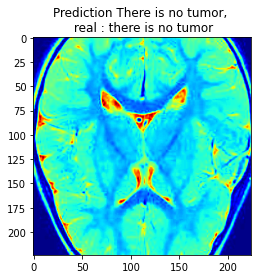

real : tensor([0])


In [117]:
device = torch.device("cpu")
model = torch.load('model.pt', map_location=torch.device('cpu'))
imge_datasets = {'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), 
                    data_transforms['val'])}
data_loaders = {'val': torch.utils.data.DataLoader(imge_datasets['val'], batch_size = 1,
                    shuffle=True, num_workers=0)}

for inputs, labels in data_loaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(inputs)
    print(torch.argmax(outputs))
    inputs = inputs.squeeze(0)
    inputs = np.array(inputs.permute(1,2,0))
    inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)
    plt.imshow(inputs, cmap="jet")
    if torch.argmax(outputs) == 1 and labels.item() == 1:
        plt.title("Prediction : There is a tumor, \n real there is a tumor")
    elif torch.argmax(outputs) == 0 and labels.item() == 0:
        plt.title("Prediction There is no tumor, \n real : there is no tumor")
    else:
        plt.title("False")
    plt.show()
    print(f"real : {labels}")
